In [4]:
library(ggplot2)
library(plyr)
library(dplyr)
library(data.table)
library(tidyr)
library(tidyverse)
library(ggplot2)
library(ggsignif) 
library(ggpubr) 
library(reshape2)
library(ggsci) 
library(stringr)
library(ggvenn)
library(ggpubr)

library(dowser)
library(ggtree)

options(repr.matrix.max.rows=600, repr.matrix.max.cols=200) 
options(repr.plot.width = 6, repr.plot.height = 6)

In [5]:
#IG类型比较
mypal <- ggsci::pal_npg(palette ="nrc", alpha = 0.7)(10)
mypal2<-ggsci::pal_jama(palette ="default", alpha = 0.7)(6)
mypal3<-ggsci::pal_lancet(palette ="lanonc", alpha = 0.7)(9)
mypal4 <- ggsci::pal_npg(palette ="nrc", alpha = 0.5)(10)
mypal5<-ggsci::pal_jama(palette ="default", alpha = 0.5)(6)
mypal6<-ggsci::pal_lancet(palette ="lanonc", alpha = 0.5)(9)
mypal7 <- ggsci::pal_npg(palette ="nrc", alpha = 0.3)(10)
mypal8<-ggsci::pal_jama(palette ="default", alpha = 0.3)(6)
mypal9<-ggsci::pal_lancet(palette ="lanonc", alpha = 0.3)(9)

mypal<-c(mypal3,mypal2,mypal,mypal6,mypal5,mypal4,mypal9,mypal8,mypal7)
mypal[3]<-"#FFBD7A"


## 1.1 读取L样本与T样本的平均overlap数据

In [7]:
db<-fread("all3up_clone-pass_germ-pass_mutation-pass_selected_rows.tsv")%>%as.data.frame()
db$sample=str_split(db$sequence_id,"_",simplify = TRUE)[,1]
db$patient=str_sub(db$sequence_id,1,7)
db$tissue=str_sub(db$sequence_id,8,8)
db$tissue<-factor(db$tissue,levels=c("T","N","L"),ordered = TRUE)
#db$c_call<-factor(db$c_call,levels=c("IGHD","IGHM","IGHA1","IGHA2","IGHG1","IGHG2","IGHG3","IGHG4","IGHE"),ordered = TRUE)
db$with_l<-""
patients_with_L<-db$patient[db$tissue=="L"] %>% unique()
patients_with_L %>%length()

db$with_l[db$patient %in% patients_with_L]<-"with_L"
db$with_l[!db$patient %in% patients_with_L]<-"without_L"
db_with_L<-db[db$with_l=="with_L",]

### step1 计算所有L样本的平均和中位数突变频率
L_data<-db[db$tissue=="L",]


[1] 27

In [11]:

L_sample_mutation_level<-tibble()
samples<-unique(db_with_L$sample)[order(unique(db_with_L$sample),decreasing = FALSE)]
for (s in samples){
    data_s<-L_data[L_data$sample==s,]
    
    p=substr(s,1,7)
    data_T<-db_with_L[db_with_L$patient==p & db_with_L$tissue=="T",]
    meanT=mean(data_T$mu_freq)
    medianT=median(data_T$mu_freq)

    row_s<-c(s,mean(data_s$mu_freq),median(data_s$mu_freq),mean(data_s$mu_freq)-meanT,median(data_s$mu_freq)-medianT)
    L_sample_mutation_level<-rbind(L_sample_mutation_level,row_s)
}


colnames(L_sample_mutation_level)<-c("sample","average_mutation","median_mutation","delta_average_mutation","delta_median_mutation")
L_sample_mutation_level[1:3,]


### step2 计算所有L样本与T的平均overlap(jaccard)和中位数overlap
jac_long<-fread("Fig7-sample_seq_overlap_addflag.csv") %>% as.data.frame()
jac_LoT<-jac_long[jac_long$flag=="self.ToL",]

L_T_jac_level<-tibble()
samples<-unique(jac_LoT$sample2)[order(unique(jac_LoT$sample2),decreasing = FALSE)]
for (s in samples){
    data_s<-jac_LoT[jac_LoT$sample2==s,]
    row_s<-c(s,mean(data_s$jaccard_index),median(data_s$jaccard_index))
    L_T_jac_level<-rbind(L_T_jac_level,row_s)
}

colnames(L_T_jac_level)<-c("sample","average_jaccard","median_jaccard")
L_T_jac_level[1:3,]

### step3 根据L样本名merge数据，分析相关性。
L_jac_mu_data<-merge(L_T_jac_level,L_sample_mutation_level,by="sample")
L_jac_mu_data[,2:7]<-apply(L_jac_mu_data[,2:7],2,as.numeric)

L_jac_mu_data$patient<-substr(L_jac_mu_data$sample,1,7)
L_jac_mu_data[1:3,]



,sample,average_mutation,median_mutation,delta_average_mutation,delta_median_mutation
,<chr>,<chr>,<chr>,<chr>,<chr>
1,ESCC007L1,0.0320127155313407,0.0275293671845396,-0.017086572756059,-0.014724153942221
2,ESCC007L2,0.0243811153626213,0.0148698884758364,-0.0247181729247784,-0.0273836326509242
3,ESCC007L3,0.0369614814743971,0.0353982300884956,-0.0121378068130026,-0.00685529103826499


,sample,average_jaccard,median_jaccard
,<chr>,<chr>,<chr>
1,ESCC007L1,0.0641146111851165,0.0517737296260786
2,ESCC007L2,0.0743262118270362,0.0916568742655699
3,ESCC007L3,0.120291844836482,0.137911136757069


,sample,average_jaccard,median_jaccard,average_mutation,median_mutation,delta_average_mutation,delta_median_mutation,patient
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,ESCC007L1,0.06411461,0.05177373,0.03201272,0.02752937,-0.01708657,-0.014724154,ESCC007
2,ESCC007L2,0.07432621,0.09165687,0.02438112,0.01486989,-0.02471817,-0.027383633,ESCC007
3,ESCC007L3,0.12029184,0.13791114,0.03696148,0.03539823,-0.01213781,-0.006855291,ESCC007


## 1.2 计算所有L样本中IgD IgM占比

LAI与IGG和突变增加水平正相关，IGM、IGD、IGA等正相关，IGE与突变水平正相关

,sample,average_jaccard,median_jaccard,average_mutation,median_mutation,delta_average_mutation,delta_median_mutation,patient
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,ESCC007L1,0.06411461,0.05177373,0.03201272,0.02752937,-0.01708657,-0.014724154,ESCC007
2,ESCC007L2,0.07432621,0.09165687,0.02438112,0.01486989,-0.02471817,-0.027383633,ESCC007
3,ESCC007L3,0.12029184,0.13791114,0.03696148,0.03539823,-0.01213781,-0.006855291,ESCC007


,IGHD,IGHM,IGHA,IGHG,IGHE,average_jaccard,median_jaccard,average_mutation,median_mutation,delta_average_mutation,delta_median_mutation,IGHDM
IGHD,1.000000000,0.47748664,0.225253199,-0.479087666,-0.059536962,-0.01874131,-0.0634879,0.34636278,0.359598831,-0.062431979,-0.007145123,0.53055372
IGHM,0.477486636,1.00000000,0.509404773,-0.878104392,0.064118099,-0.37390077,-0.3862878,0.04483769,0.028661383,-0.272825971,-0.306807080,0.99326819
IGHA,0.225253199,0.50940477,1.000000000,-0.809585844,-0.014891744,-0.30482807,-0.2827173,0.14383803,0.093521861,0.007544712,0.008847396,0.51798171
IGHG,-0.479087666,-0.87810439,-0.809585844,1.000000000,0.004702656,0.39503894,0.3966509,-0.15089424,-0.128911445,0.142698184,0.140201373,-0.88483566
IGHE,-0.059536962,0.06411810,-0.014891744,0.004702656,1.000000000,-0.10549339,-0.1208583,0.10141786,0.116779457,0.015675095,0.023355891,0.05643647
average_jaccard,-0.018741307,-0.37390077,-0.304828073,0.395038945,-0.105493389,1.00000000,0.9872717,-0.18063396,-0.251302649,0.539296570,0.521819366,-0.37791771
median_jaccard,-0.063487901,-0.38628776,-0.282717256,0.396650925,-0.120858262,0.98727169,1.0000000,-0.21450864,-0.288544522,0.562053899,0.535837382,-0.39052195
average_mutation,0.346362783,0.04483769,0.143838033,-0.150894238,0.101417864,-0.18063396,-0.2145086,1.00000000,0.959292228,0.043638732,0.080438558,0.08913256
median_mutation,0.359598831,0.02866138,0.093521861,-0.128911445,0.116779457,-0.25130265,-0.2885445,0.95929223,1.000000000,0.005970473,0.092596613,0.07339051
delta_average_mutation,-0.062431979,-0.27282597,0.007544712,0.142698184,0.015675095,0.53929657,0.5620539,0.04363873,0.005970473,1.000000000,0.960920538,-0.29377918


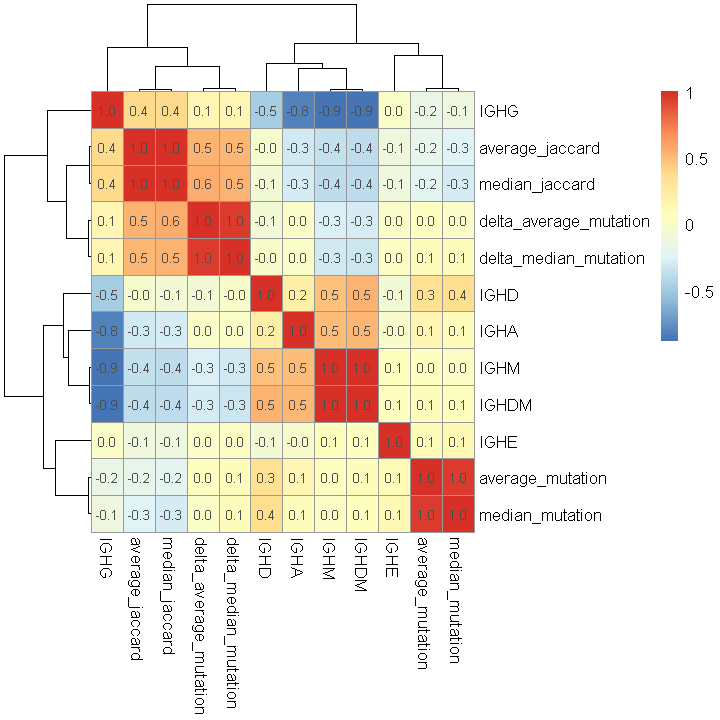

In [12]:
L_data<-db[grep("L",db$sample),]
L_data$c_call<-substr(L_data$c_call,1,4)
L_data$c_call<-factor(L_data$c_call,levels=c("IGHD","IGHM","IGHA","IGHG","IGHE"))

IGDIGM_prop_in_L<-tibble()

for (s in sort(unique(L_data$sample))){
    L_data_s<-L_data[L_data$sample==s,]
    IGH_type_prop<-prop.table(table(L_data_s$c_call))
    data_r<-c(s,IGH_type_prop)
    IGDIGM_prop_in_L<-rbind(IGDIGM_prop_in_L,data_r)
}

colnames(IGDIGM_prop_in_L)=c("sample","IGHD","IGHM","IGHA","IGHG","IGHE")
IGDIGM_prop_in_L[,2:6]<-apply(IGDIGM_prop_in_L[,2:6],2,as.numeric)

### step3 根据L样本名merge数据，分析相关性。
L_jac_mu_data<-merge(L_T_jac_level,L_sample_mutation_level,by="sample")
L_jac_mu_data[,2:7]<-apply(L_jac_mu_data[,2:7],2,as.numeric)

L_jac_mu_data$patient<-substr(L_jac_mu_data$sample,1,7)
L_jac_mu_data[1:3,]

L_features<-merge(IGDIGM_prop_in_L,L_jac_mu_data,by="sample")
L_features$IGHDM<-L_features$IGHD+L_features$IGHM

library(pheatmap)
cor_mat<-cor(L_features[,-c(1,13)],method="spearman",)
cor_mat

pheatmap(cor_mat,display_numbers = T, number_format = "%.1f")

## 计算4个相关性和p

In [13]:
options(repr.plot.width = 5, repr.plot.height = 5)
cor_LAI_IGHDM<-cor.test(L_features$IGHD+L_features$IGHM,L_features$average_jaccard,method="spearman")
cor_LAI_IGHG<-cor.test(L_features$IGHG,L_features$average_jaccard,method="spearman")
cor_LAI_mu<-cor.test(L_features$average_mutation,L_features$average_jaccard,method="spearman")
cor_LAI_delt_mu<-cor.test(L_features$delta_average_mutation,L_features$average_jaccard,method="spearman")

#annotate("text",x=-Inf,y=Inf,vjust=1.5,hjust=-0.2,label=paste("chisq.test p=",p))+

r1<-paste0("Spearman's Rho = ",round(cor_LAI_IGHDM$estimate,digits=2))
p1<-paste0("p = ",round(cor_LAI_IGHDM$p.value,digits=5))

r2<-paste0("Spearman's Rho = ",round(cor_LAI_IGHG$estimate,digits=2))
p2<-paste0("p = ",round(cor_LAI_IGHG$p.value,digits=5))

r3<-paste0("Spearman's Rho = ",round(cor_LAI_mu$estimate,digits=2))
p3<-paste0("p = ",round(cor_LAI_mu$p.value,digits=5))

r4<-paste0("Spearman's Rho = ",round(cor_LAI_delt_mu$estimate,digits=2))
p4<-paste0("p = ",round(cor_LAI_delt_mu$p.value,digits=5))


Warning message in cor.test.default(L_features$IGHD + L_features$IGHM, L_features$average_jaccard, :
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(L_features$IGHG, L_features$average_jaccard, :
"Cannot compute exact p-value with ties"


## Fig7E-H

### LAI相关性作图

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


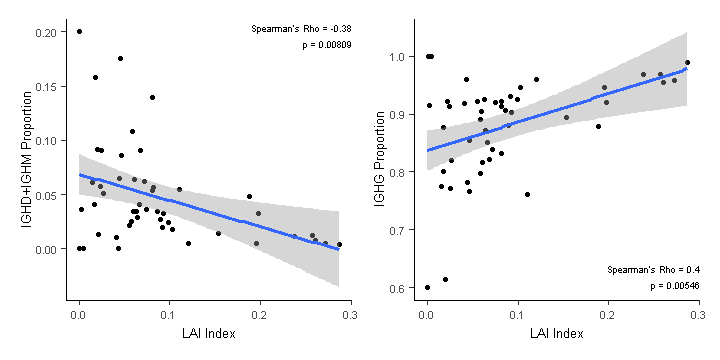

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


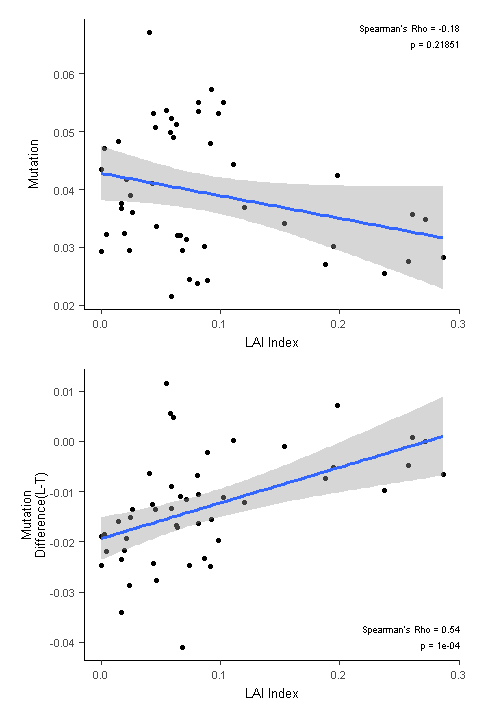

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


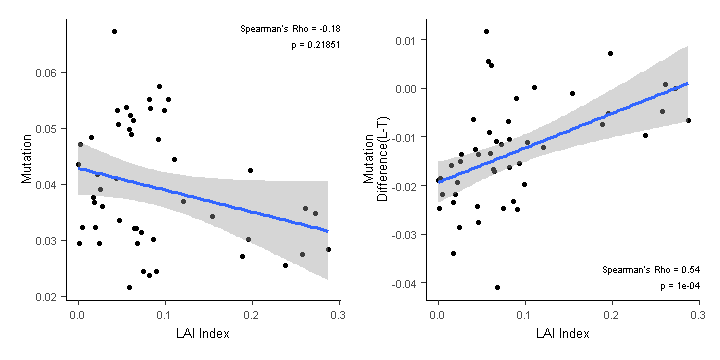

null device 
          1

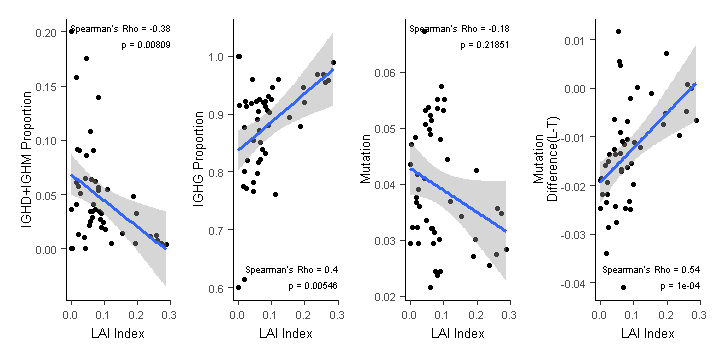

In [14]:

g_dm<-ggplot(L_features,aes(x=average_jaccard,y=IGHD+IGHM))+geom_point(size=1)+
geom_smooth(method="lm")+
labs(x="LAI Index",y="IGHD+IGHM Proportion")+
annotate("text",x=Inf,y=Inf,vjust=c(1.5,3.5),hjust=c(1,1),label=c(r1,p1),size=2)+
theme_classic2()+
theme(text =element_text(size=8))

g_g<-ggplot(L_features,aes(x=average_jaccard,y=IGHG))+
geom_point(size=1)+
geom_smooth(method="lm")+
labs(x="LAI Index",y="IGHG Proportion")+
annotate("text",x=Inf,y=-Inf,vjust=c(-3.5,-1.5),hjust=c(1,1),label=c(r2,p2),size=2)+
theme_classic2()+
theme(text =element_text(size=8))

g_mu<-ggplot(L_features,aes(x=average_jaccard,y=average_mutation))+geom_point(size=1)+
geom_smooth(method="lm")+
labs(x="LAI Index",y="Mutation")+
annotate("text",x=Inf,y=Inf,vjust=c(1.5,3.5),hjust=c(1,1),label=c(r3,p3),size=2)+
theme_classic2()+
theme(text =element_text(size=8))

g_delt_mu<-ggplot(L_features,aes(x=average_jaccard,y=delta_average_mutation))+
geom_point(size=1)+
geom_smooth(method="lm")+
labs(x="LAI Index",y="Mutation\nDifference(L-T)")+
annotate("text",x=Inf,y=-Inf,vjust=c(-3.5,-1.5),hjust=c(1,1),label=c(r4,p4),size=2)+
theme_classic2()+
theme(text =element_text(size=8))

library(patchwork)
options(repr.plot.width = 6, repr.plot.height = 3)
g_dm+g_g+plot_layout(ncol=2)

options(repr.plot.width = 4, repr.plot.height = 6)
g_mu+g_delt_mu+plot_layout(ncol=1)

options(repr.plot.width = 6, repr.plot.height = 3)
g_mu+g_delt_mu+plot_layout(ncol=2)


#pdf("Fig7.LAI_cor_mutation.pdf",8,2)
g_dm+g_g+g_mu+g_delt_mu+plot_layout(nrow=1)
dev.off()

In [16]:
write.csv(L_features,"Fig7EFGH.csv",row.names=FALSE,quote=FALSE)

## Fig7D

### LAI排序作图

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


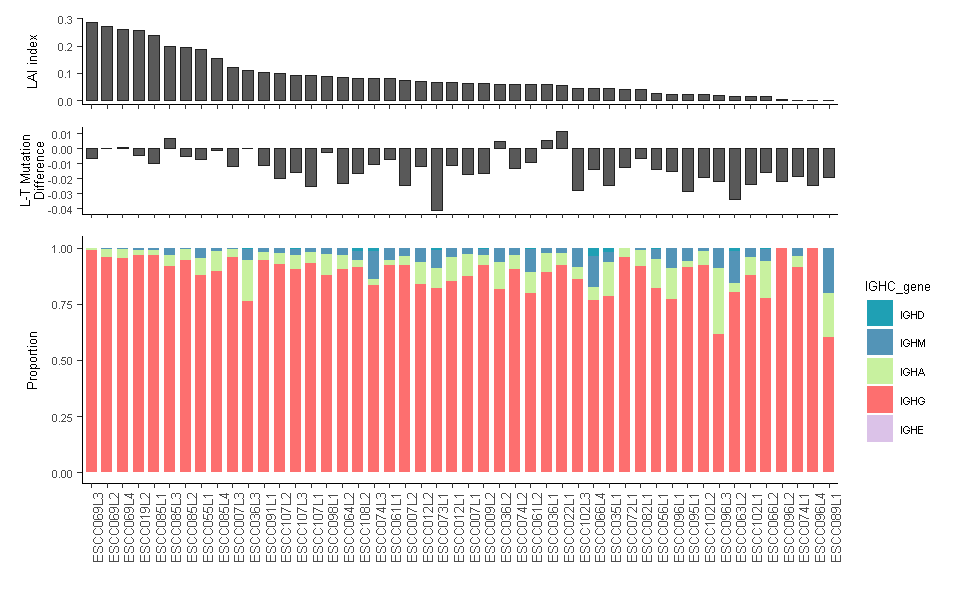

In [17]:
options(repr.plot.width = 8, repr.plot.height = 5)

level_LAI<-L_jac_mu_data$sample[order(L_jac_mu_data$average_jaccard,decreasing = TRUE)]

IGDIGM_prop_in_L$sample<-factor(IGDIGM_prop_in_L$sample,levels=level_LAI)

ce<-melt(data = IGDIGM_prop_in_L,id.vars=c("sample"),variable="IGHC_gene",value.name="Proportion")
bot<-ggplot(ce,aes(x=sample,y=Proportion,fill=IGHC_gene))+
    geom_bar(aes(x=sample,y=Proportion,fill=IGHC_gene),stat="identity",width=0.7,size=0.5)+
    theme_classic()+
    labs(x='',y='Proportion')+
    scale_fill_manual(values=    c("#1fa0b4","#5394b7","#c8f19f","#fd6f6f","#dbc2e8"))+
    theme(text =element_text(size=8),
      axis.text.x =element_text(angle=90,size=8))


L_jac_mu_data$sample<-factor(L_jac_mu_data$sample,levels=level_LAI)
top<-ggplot(L_jac_mu_data,aes(x=sample,y=average_jaccard,col=IGHC_gene))+
geom_bar(stat="identity",width=0.7,size=0.5,colour="#222222")+
theme_classic()+
xlab(NULL)+
theme(text =element_text(size=8),axis.text.x = element_blank())+
ylab("LAI index")

top_mu<-ggplot(L_jac_mu_data,aes(x=sample,y=delta_average_mutation,col=level_LAI))+
geom_bar(stat="identity",width=0.7,size=0.5,colour="#222222")+
theme_classic()+
xlab(NULL)+
theme(text =element_text(size=8),axis.text.x = element_blank())+
ylab("L-T Mutation\nDifference")

library(patchwork)
top+top_mu+bot+plot_layout(ncol=1,heights = c(0.7,0.7,2))

In [24]:
pdf('Fig6.LAI_Mutation_IGHproportion.pdf',6.5,5)
top+top_mu+bot+plot_layout(ncol=1,heights = c(0.7,0.7,2))
dev.off()

png 
  2

In [18]:
write.csv(L_jac_mu_data,"Fig7up_middle.csv",quote=FALSE,row.names=FALSE)
write.csv(IGDIGM_prop_in_L,"Fig7bottom.csv",quote=FALSE,row.names=FALSE)


## 【***】Fig7BC

In [19]:
db<-fread("all3up_clone-pass_germ-pass_mutation-pass_selected_rows.tsv")%>%as.data.frame()
db$sample=str_split(db$sequence_id,"_",simplify = TRUE)[,1]
db$patient=str_sub(db$sequence_id,1,7)
db$tissue=str_sub(db$sequence_id,8,8)
db$tissue<-factor(db$tissue,levels=c("T","N","L"),ordered = TRUE)
#db$c_call<-factor(db$c_call,levels=c("IGHD","IGHM","IGHA1","IGHA2","IGHG1","IGHG2","IGHG3","IGHG4","IGHE"),ordered = TRUE)
db$with_l<-""
patients_with_L<-db$patient[db$tissue=="L"] %>% unique()
patients_with_L %>%length()

db$with_l[db$patient %in% patients_with_L]<-"with_L"
db$with_l[!db$patient %in% patients_with_L]<-"without_L"
db_with_L<-db[db$with_l=="with_L",]

### step1 计算所有L样本的平均和中位数突变频率
L_data<-db[db$tissue=="L",]

L_sample_mutation_level<-tibble()
samples<-unique(db_with_L$sample)[order(unique(db_with_L$sample),decreasing = FALSE)]
for (s in samples){
    data_s<-L_data[L_data$sample==s,]
    
    p=substr(s,1,7)
    data_T<-db_with_L[db_with_L$patient==p & db_with_L$tissue=="T",]
    meanT=mean(data_T$mu_freq)
    medianT=median(data_T$mu_freq)

    row_s<-c(s,mean(data_s$mu_freq),median(data_s$mu_freq),mean(data_s$mu_freq)-meanT,median(data_s$mu_freq)-medianT)
    L_sample_mutation_level<-rbind(L_sample_mutation_level,row_s)
}

colnames(L_sample_mutation_level)<-c("sample","average_mutation","median_mutation","delta_average_mutation","delta_median_mutation")
L_sample_mutation_level[1:3,]


### step2 计算所有L样本与T的平均overlap(jaccard)和中位数overlap
jac_long<-fread("Fig7-sample_seq_overlap_addflag.csv") %>% as.data.frame()
jac_LoT<-jac_long[jac_long$flag=="self.ToL",]

L_T_jac_level<-tibble()
samples<-unique(jac_LoT$sample2)[order(unique(jac_LoT$sample2),decreasing = FALSE)]
for (s in samples){
    data_s<-jac_LoT[jac_LoT$sample2==s,]
    row_s<-c(s,mean(data_s$jaccard_index),median(data_s$jaccard_index))
    L_T_jac_level<-rbind(L_T_jac_level,row_s)
}

colnames(L_T_jac_level)<-c("sample","average_jaccard","median_jaccard")
L_T_jac_level[1:3,]

### step3 根据L样本名merge数据，分析相关性。
L_jac_mu_data<-merge(L_T_jac_level,L_sample_mutation_level,by="sample")
L_jac_mu_data[,2:7]<-apply(L_jac_mu_data[,2:7],2,as.numeric)

L_jac_mu_data$patient<-substr(L_jac_mu_data$sample,1,7)
L_jac_mu_data[1:3,]


[1] 27

,sample,average_mutation,median_mutation,delta_average_mutation,delta_median_mutation
,<chr>,<chr>,<chr>,<chr>,<chr>
1,ESCC007L1,0.0320127155313407,0.0275293671845396,-0.017086572756059,-0.014724153942221
2,ESCC007L2,0.0243811153626213,0.0148698884758364,-0.0247181729247784,-0.0273836326509242
3,ESCC007L3,0.0369614814743971,0.0353982300884956,-0.0121378068130026,-0.00685529103826499


,sample,average_jaccard,median_jaccard
,<chr>,<chr>,<chr>
1,ESCC007L1,0.0641146111851165,0.0517737296260786
2,ESCC007L2,0.0743262118270362,0.0916568742655699
3,ESCC007L3,0.120291844836482,0.137911136757069


,sample,average_jaccard,median_jaccard,average_mutation,median_mutation,delta_average_mutation,delta_median_mutation,patient
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,ESCC007L1,0.06411461,0.05177373,0.03201272,0.02752937,-0.01708657,-0.014724154,ESCC007
2,ESCC007L2,0.07432621,0.09165687,0.02438112,0.01486989,-0.02471817,-0.027383633,ESCC007
3,ESCC007L3,0.12029184,0.13791114,0.03696148,0.03539823,-0.01213781,-0.006855291,ESCC007


,patient,individual's max LAI,individual's min LAI
,<chr>,<dbl>,<dbl>
1,ESCC007,0.12029184,0.06411461
2,ESCC009,0.06282372,0.06282372
3,ESCC012,0.07189503,0.06612658



载入程辑包：'survminer'


The following object is masked from 'package:survival':

    myeloma




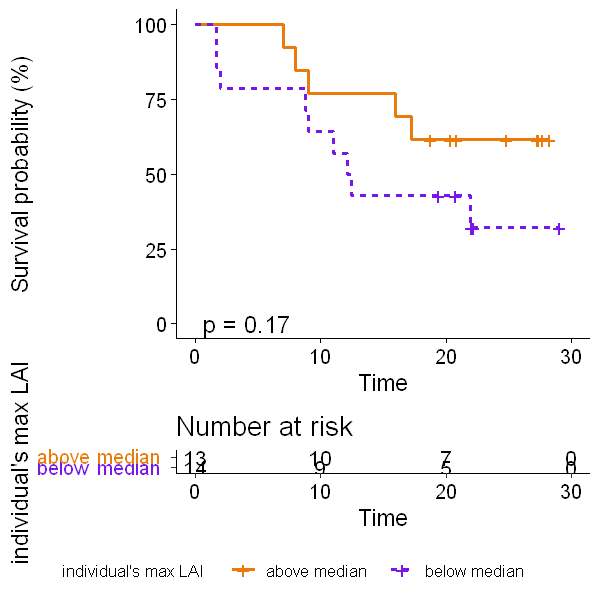

null device 
          1

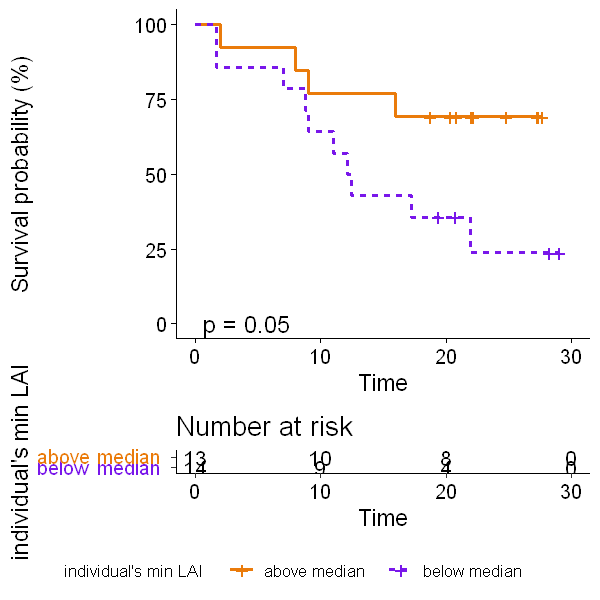

In [20]:
data<-L_jac_mu_data
surv_data<-tibble()
for(p in unique(data$patient)){
    data_p<-data[data$patient==p,]
    row<-c(p,max(data_p$average_jaccard),min(data_p$average_jaccard))
    surv_data<-rbind(surv_data,row)
}
colnames(surv_data)<-c("patient","individual's max LAI","individual's min LAI")
surv_data[,2:3]<-apply(surv_data[,2:3],2,as.numeric)
surv_data[1:3,]

data<-surv_data

library(survival)
library(survminer)
options(repr.plot.width = 5, repr.plot.height = 5)

MR_survival_gene_data<-fread("Fig7-MR_survival_gene_data.test.csv") %>% as.data.frame(check.names=FALSE)
rows_selected<-!duplicated(MR_survival_gene_data$Patient_ID)
cols_selected<-colnames(MR_survival_gene_data) %in% c('Patient_ID','Gender','Age','Location','Smoking_status','Drinking_status','T','N','M','TNM','Tumor_grade','Lymphatic_metastasis','Survival_status','Survival_time')
MR_survival_data<-MR_survival_gene_data[rows_selected,cols_selected]
colnames(MR_survival_data)[1]<-"patient"

data<-merge(MR_survival_data,data,by="patient")

genes<-c("individual's max LAI","individual's min LAI")
#pdf("MR_individual_LAI_survival.pdf",5,6)
for (gene in genes){
data$gene_flag[data[,gene]>median(data[,gene])]<-"high"
data$gene_flag[data[,gene]<=median(data[,gene])]<-"low"

fit<-survfit(Surv(Survival_time,Survival_status) ~gene_flag, data=data)

xx<-ggsurvplot(fit, data = data,
           conf.int = FALSE,
           pval = TRUE,
           fun = "pct",
           risk.table = TRUE,
           size = 1,
           linetype = "strata",
           palette = c(rgb(234,123,11,maxColorValue=255),rgb(121,23,234,maxColorValue=255)),
           legend = "bottom",
           legend.labs = c("above median","below median"),
           legend.title=(gene),
           add.title=(gene)
           )
print(xx)
}
dev.off()

In [22]:

write.csv(data[,c(1,13,14,15,16)],"Fig7BC.csv",quote=FALSE,row.names=FALSE)